In [1]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt  

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [2]:
# filter for the job titles and country
df_IR = df[(df['job_country'] == 'Ireland')].dropna(subset=['salary_year_avg'])

In [3]:
job_titles = df_IR['job_title_short'].value_counts().index[:6].tolist()

# filter the df for the top 6 job titles
df_IR_top6 = df_IR[df_IR['job_title_short'].isin(job_titles)]

# order the job titles by median salary
job_order = df_IR_top6.groupby('job_title_short')['salary_year_avg'].median().sort_values(ascending=False).index

job_titles

['Data Analyst',
 'Data Engineer',
 'Data Scientist',
 'Senior Data Engineer',
 'Machine Learning Engineer',
 'Senior Data Scientist']

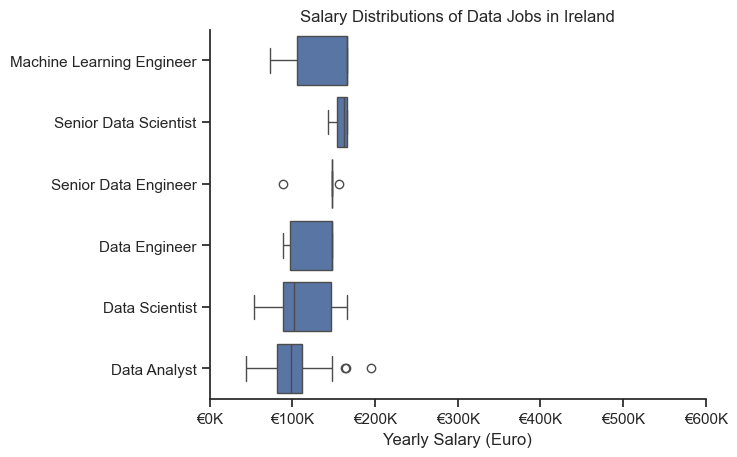

In [5]:
sns.boxplot(data=df_IR_top6, x='salary_year_avg', y='job_title_short', order=job_order)
sns.set_theme(style='ticks')
sns.despine()

# this is all the same
plt.title('Salary Distributions of Data Jobs in Ireland')
plt.xlabel('Yearly Salary (Euro)')
plt.ylabel('')
plt.xlim(0, 600000) 
ticks_x = plt.FuncFormatter(lambda y, pos: f'€{int(y/1000)}K')
plt.gca().xaxis.set_major_formatter(ticks_x)
plt.show()

In [6]:
# Only get data analyst jobs in the US
df_DA_IR = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'Ireland')].copy()

# Drop NaN values from the 'salary_year_avg' column for accurate visualization
df_DA_IR = df_DA_IR.dropna(subset=['salary_year_avg'])

df_DA_US = df_DA_IR.explode('job_skills')

df_DA_IR[['salary_year_avg', 'job_skills']].head(5)

,salary_year_avg,job_skills
59621,72900.0,"[python, r, azure, power bi, tableau]"
61908,80850.0,"[sql, tableau, unreal]"
90848,111175.0,"[sql, r, python, scala]"
138703,111175.0,"[r, python, bash, express]"
155867,43200.0,"[gdpr, power bi, excel, powerpoint, sharepoint]"


In [10]:
# Step 1: Explode the job_skills column so each skill has its own row
df_exploded = df_DA_IR.explode('job_skills')

# Step 2: Group by individual skills and calculate count and median salary
df_DA_top_pay = (
    df_exploded.groupby('job_skills')['salary_year_avg']
    .agg(['count', 'median'])
    .sort_values(by='median', ascending=False)
    .head(10)
)

# Step 3: View the result
df_DA_top_pay

,count,median
job_skills,,
git,1,194500.0
linux,1,194500.0
oracle,1,165000.0
nosql,1,163782.0
unify,1,163782.0
snowflake,3,147500.0
asana,1,147500.0
airflow,1,147500.0
slack,1,147500.0


In [12]:
# Explode job_skills so each skill is in its own row
df_exploded = df_DA_IR.explode('job_skills')

# Group by individual skill, then aggregate count and median salary
df_DA_skills = (
    df_exploded.groupby('job_skills')['salary_year_avg']
    .agg(['count', 'median'])
    .sort_values(by='count', ascending=False)
)

# Keep top 10 most common skills, sorted by highest median salary
df_DA_skills = df_DA_skills.head(10).sort_values(by='median', ascending=False)

df_DA_skills

,count,median
job_skills,,
snowflake,3,147500.0
python,6,104837.5
azure,5,100500.0
r,8,100500.0
sql,11,98500.0
sas,4,86700.0
tableau,9,80850.0
unreal,3,80850.0
power bi,5,72900.0


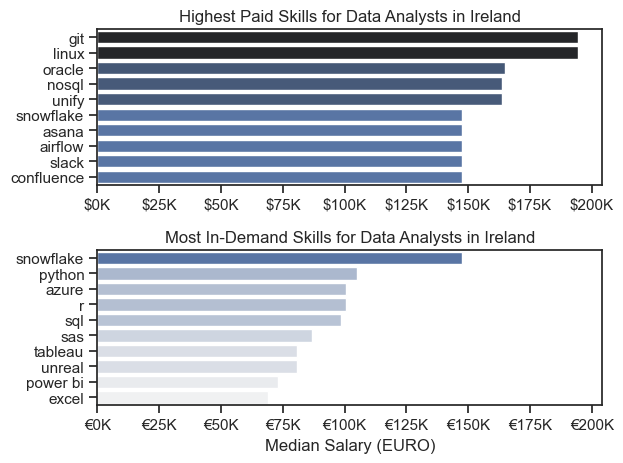

In [13]:
fig, ax = plt.subplots(2, 1)  

# Top 10 Highest Paid Skills for Data Analysts
sns.barplot(data=df_DA_top_pay, x='median', y=df_DA_top_pay.index, hue='median', ax=ax[0], palette='dark:b_r')
ax[0].legend().remove()
# original code:
# df_DA_top_pay[::-1].plot(kind='barh', y='median', ax=ax[0], legend=False) 
ax[0].set_title('Highest Paid Skills for Data Analysts in Ireland')
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x/1000)}K'))


# Top 10 Most In-Demand Skills for Data Analysts')
sns.barplot(data=df_DA_skills, x='median', y=df_DA_skills.index, hue='median', ax=ax[1], palette='light:b')
ax[1].legend().remove()
# original code:
# df_DA_skills[::-1].plot(kind='barh', y='median', ax=ax[1], legend=False)
ax[1].set_title('Most In-Demand Skills for Data Analysts in Ireland')
ax[1].set_ylabel('')
ax[1].set_xlabel('Median Salary (EURO)')
ax[1].set_xlim(ax[0].get_xlim())  # Set the same x-axis limits as the first plot
ax[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'€{int(x/1000)}K'))

sns.set_theme(style='ticks')
plt.tight_layout()
plt.show()